In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import plotly.express as px

from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import VotingRegressor
from sklearn.feature_selection import SelectKBest

from anderson_case_study1 import *

### Problem Statement From Video
Use the data, which contains properties of superconductors that have already been found (e.g., material composition and temperature at which the material superconducts), to produce a model that can predict: what new materials superconductors can be superconductors and the temperature at which they become super conductors

Answers to questions from video
- There is a metadata file that will describe each column
- There is no missing data
- In order for the model to meet the "interpretable / explainable" requirement, we must provide information on the relative importance of each feature

### Problem Statement From Assignment Link
Build a linear regression model using L1 or L2 regularization (or both) to predict the Critical Temperature as closely as possible. In addition, include in your write-up which variable carries the most importance.

In [2]:
'''plt.figure(figsize = (15,8));
sns.histplot(age, x = "age_im", bins=30,  stat="density", color ='lightcoral');
sns.kdeplot(data=age, x = "age_im");
plt.xlabel('Age', weight = 1000, size=20)
plt.ylabel('Density', weight = 1000, size=20)
plt.title("Distribution of Driver's Age", size=20)


cv_pred = cross_val_predict(model_, X, y, cv=kfcv ,n_jobs=-1)

fig, ax = plt.subplots()
ax.scatter(y, cv_pred, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=4)
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title("Elastic Net CV: Predicted vs Actual")
plt.show()''';

## Section 1: Preprocessing and EDA

In [3]:
t_df = pd.read_csv("./superconduct/train.csv")
unique_df = pd.read_csv("./superconduct/unique_m.csv")

df = merge_and_clean(train_csv_df=t_df, 
                     unique_m_csv_df=unique_df)

df.head()

========================== Preprocessing Steps ==========================

Columns found in both dataframes: ['critical_temp'], duplicates will be removed prior to dataframe concatenation.

There are 9 columns that contain the exact same value for every row: ['He', 'Ne', 'Ar', 'Kr', 'Xe', 'Pm', 'Po', 'At', 'Rn']
Shape before dropping single value columns: (21263, 169), shape after dropping: (21263, 160)



number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                 1.057755          122.90607              36.161939   
2                 0.975980          122.90607              35.741099   
3                 1.022291          122.90607              33.768010   
4                 1.129224          122.90607              27.848743   

   std_atomic_mass  ...   Re   Os   Ir   Pt   Au   Hg   Tl   Pb   Bi  \
0        51.968828  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1        47.094633  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2        51.968828  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3        51.968828  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4        51.968828  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                 material  
0         Ba0.2La1.8Cu1O4  
1  Ba0.1La1.9Ag0.1Cu0.9O4  
2         Ba0.1La1.9Cu1O4  
3       Ba0.15La1.85Cu1O4  
4         Ba0.3La1.7Cu1O4  

[5 rows x 160 columns]

In [4]:
t_df.shape

(21263, 82)

In [5]:
df.shape

(21263, 160)

In [6]:
df.dtypes.value_counts()

float64    156
int64        3
object       1
dtype: int64

In [7]:
df.select_dtypes(include="int64").head(2)

number_of_elements  range_atomic_radius  range_Valence
0                   4                  205              1
1                   5                  205              2

In [8]:
df.select_dtypes(include="object").head(2)

material
0         Ba0.2La1.8Cu1O4
1  Ba0.1La1.9Ag0.1Cu0.9O4

In [9]:
model_df = df.select_dtypes(exclude="object")
model_df.shape

(21263, 159)

### 1.2 EDA

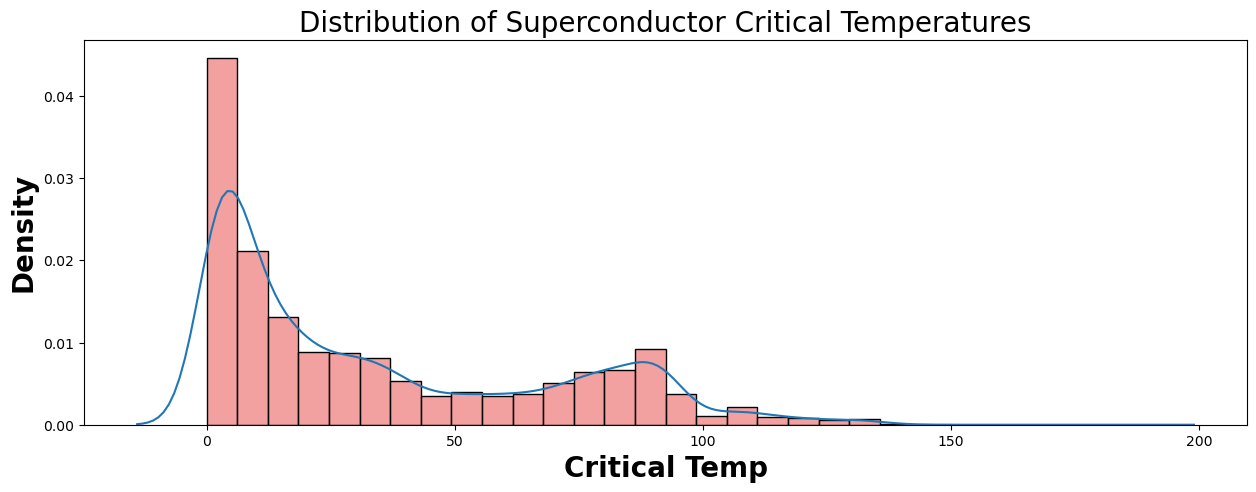

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
sns.histplot(model_df, x = "critical_temp", bins=30,  stat="density", color ='lightcoral', ax=ax);
sns.kdeplot(data=model_df, x = "critical_temp");
plt.xlabel('Critical Temp', weight = 1000, size=20)
plt.ylabel('Density', weight = 1000, size=20)
ax.set_title("Distribution of Superconductor Critical Temperatures", fontsize=20)
fig.savefig("./images/critical_temp_distribution.png")

<AxesSubplot:title={'center':'Top 10 Features with largest absolute value of \nof spearman correlation with critical_temp'}>

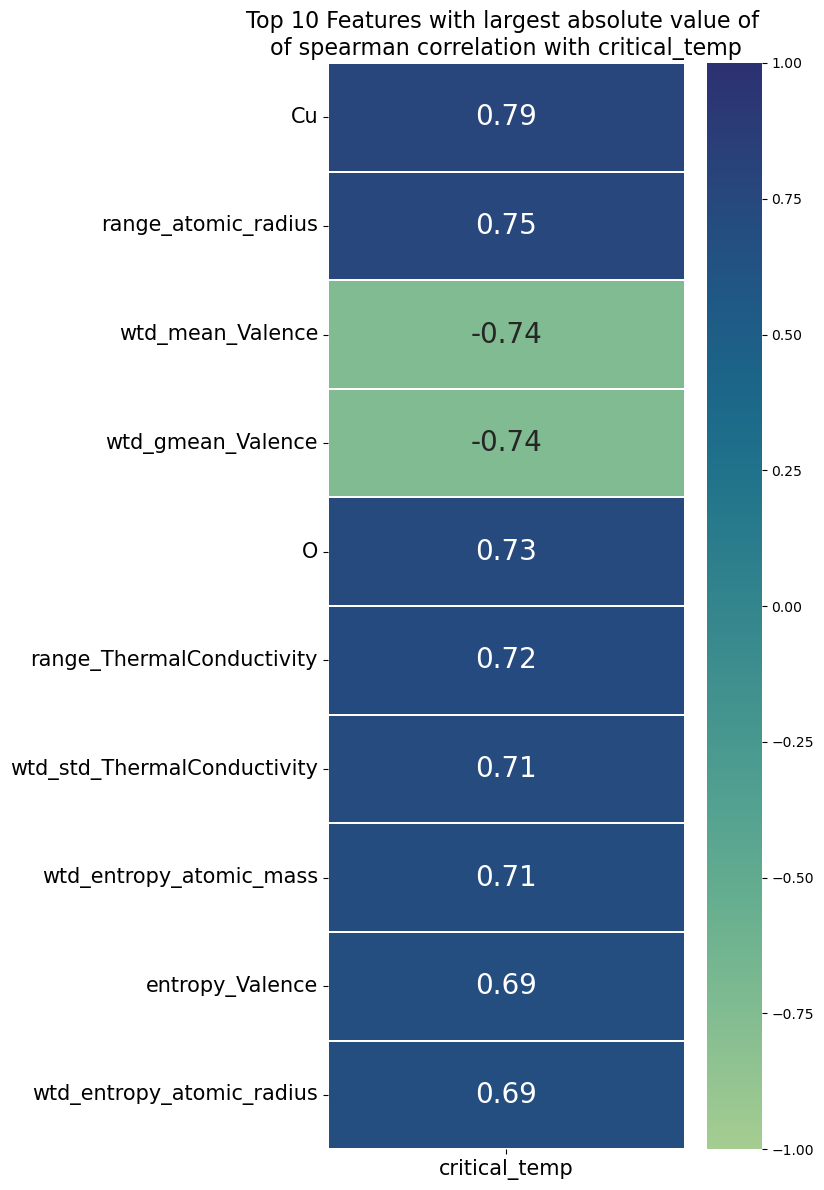

In [11]:
plot_target_correlations(model_df=model_df, 
                         corr_method="spearman", 
                         num_correlations=10, 
                         figsize=(8,12),
                         savepath="./images/top10_spearman_corr.png")

<AxesSubplot:title={'center':'Top 10 Features with largest absolute value of \nof pearson correlation with critical_temp'}>

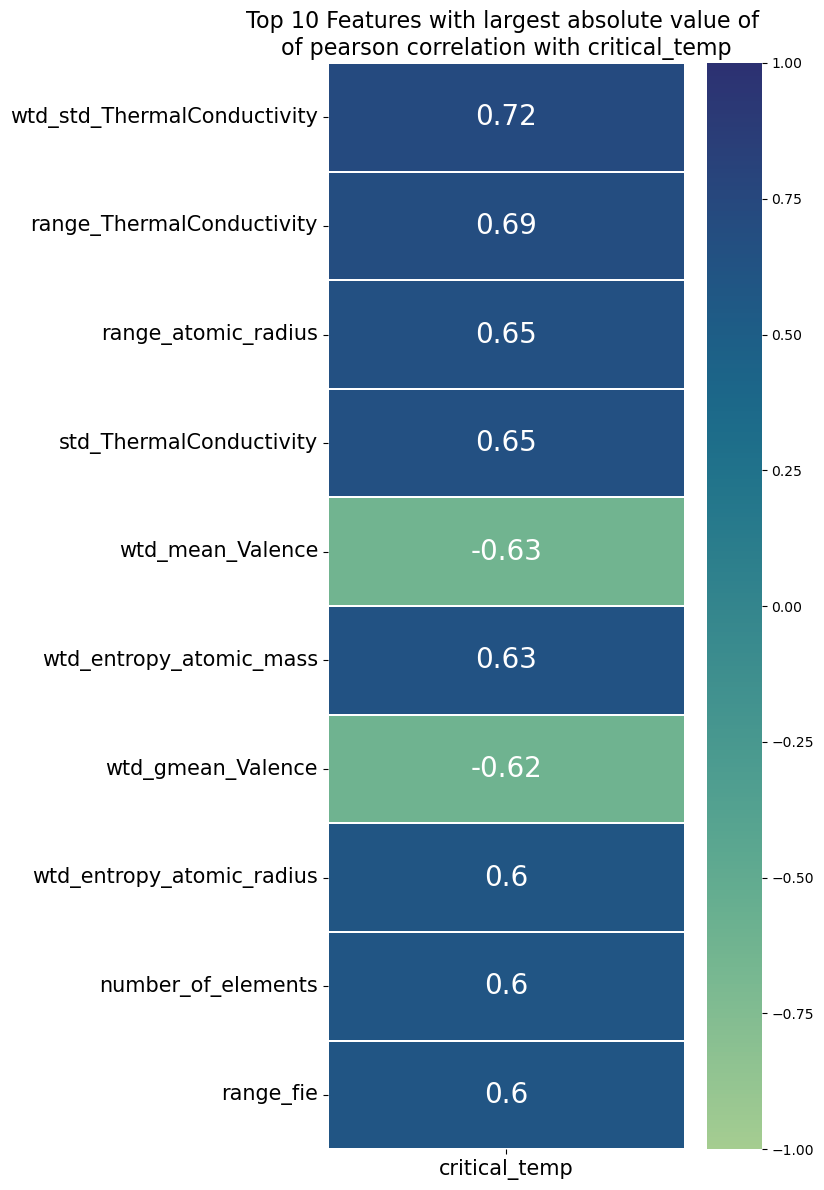

In [12]:
plot_target_correlations(model_df=model_df, 
                         corr_method="pearson", 
                         num_correlations=10, 
                         figsize=(8,12),
                         savepath="./images/top10_pearson_corr.png")

## Section 2: Baseline Models

Bias Variance Tradeoff: 

$$
\begin{eqnarray}
Expected \; Test \; MSE &=& E[y_0 - \hat{f}(x_0)]^2  &=&  var(\hat{f}(x_0)) + [Bias(\hat{f}(x_0))]^2 + var(\epsilon)
\end{eqnarray}
$$


### 2.1: Fitting baseline linear models

In [13]:
target_column = "critical_temp"
X = model_df.drop(columns=target_column)
y = model_df[target_column].to_numpy()

In [14]:
baselines = get_baseline_model_results(X=X, y=y, 
                                       shuffle=True, 
                                       random_state=42,
                                       estimators=get_baseline_estimators(),
                                       metrics=["neg_root_mean_squared_error", 
                                                "neg_mean_squared_error", 
                                                "neg_mean_absolute_error", 
                                                "r2"])

============================== Baseline Models: 5-Fold CV Metrics (All Default Hyperparameters) ============================================
Null Model (No parameters, always predicts the mean): 
MSE: 1173.30616
RMSE: 34.253557
MAE: 29.330050
R-Squared: 0.000000 (Always zero for constant model that predicts the mean) 

>>>>>>>>>>>>>>> LinearRegression <<<<<<<<<<<<<<<
Number of Non-Zero Model Parameter Estimates:
Avg: 158.0, Min: 158, Max: 158

Avg Train RMSE:16.57132, min:16.41080 max:16.67377 std:0.09298
Avg Validation RMSE: 22.61674, min:16.51315, max:46.09358 std:11.73978

Avg Train MSE:274.61738, min:269.31436 max:278.01460 std:3.07558
Avg Validation MSE: 649.33931, min:272.68427, max:2124.61823 std:737.66389

Avg Train MAE:12.36642, min:12.26305 max:12.43431 std:0.06177
Avg Validation MAE: 12.67320, min:12.39144, max:13.38984 std:0.36778

Avg Train R-Squared:0.76594, min:0.76394 max:0.76906 std:0.00189
Avg Validation R-Squared: 0.45361, min:-0.76902, max:0.76496 std:0.61133

>>>>>

## Section 3: Hyperparameter Tuning

### 3.1: Lasso Models

$$
\begin{eqnarray}
Lasso \; Loss &=& SSE + L{1} \; Penalty &=& \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2 + \alpha\sum_{j=1}^p |\beta_j|
\end{eqnarray}
$$

#### 3.1.1 Lasso GridSearch

In [15]:
#model_pipe = Pipeline(steps=[("scaler", StandardScaler()), 
#                             ("model", Lasso(max_iter=15_000, random_state=42))])

#parameter_grid = {"model__alpha":np.logspace(start=-2.3, stop=1.32, num=101), 
#                  "model__fit_intercept":[True, False]}

#gs = run_gridsearch(X=X, 
#                    y=y, 
#                    estimator=model_pipe, 
#                    param_grid=parameter_grid, 
#                    save_name=get_gs_save_name(model_name="lasso"))

In [16]:
GS_FILENAME="lasso_20220904_0646_gs"
lasso_gs = load_gs_from_pickle(pickle_filepath=f"./models/{GS_FILENAME}.pkl")
lasso_best_params = lasso_gs.best_estimator_.named_steps["model"].get_params()
lasso_best_coefs = lasso_gs.best_estimator_.named_steps["model"].coef_
lasso_gs_df = pd.DataFrame(lasso_gs.cv_results_)

lc_gs_df = gs_to_clean_df(search_results=lasso_gs.cv_results_, task="regression")

In [17]:
features = lasso_gs.best_estimator_[:-1].get_feature_names_out()

lasso_coef_df = pd.DataFrame({"Feature":features,
                              "Parameter":lasso_best_coefs})

lasso_coef_df = lasso_coef_df.reindex(lasso_coef_df["Parameter"].abs().sort_values(ascending=False).index)

#### 3.1.2 Best Lasso Model Coefficients

In [18]:
scaler = StandardScaler()
X_sc = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = model_df[target_column].to_numpy()

In [19]:
lasso_plot_dataframe = get_lasso_large_plot_df(X=X_sc, 
                                               y=y, 
                                               X_unscaled=X, 
                                               alphas=[get_gs_alphas(df=lc_gs_df.loc[lc_gs_df["fit_intercept"]==True,:])['best']], 
                                               run_rfecv=True)

============================== Lasso Parameter Estimate Summary (Alpha=1.576884920121928) =======================================
Number of Parameters Estimated: 158.0
Max Parameter Value: 10.50009500352614
75th Percentile Parameter Value: 0.0
Mean Parameter Value: 0.1641205949713159
Median Parameter Value: 0.0
Min Parameter Value: -2.6350505344493036

Number of non-zero parameter estimates: 20
Number of Parameters Eliminated by Lasso (coef shrank to zero): 138

Features Eliminated By Lasso:
std_fie, wtd_range_atomic_mass, Ga, Ge, Se, Br, Rb, Y, Ag, Zr, Nb, Mo, Tc, Ru, Rh, Zn, Cu, Ni, Co, Fe, Mn, Cr, V, Ti, Sc, std_atomic_mass, K, Cl, S, P, wtd_std_atomic_mass, Al, Pd, Cd, Na, Re, Tm, Yb, Lu, Hf, Ta, W, Os, In, Ir, Pt, Au, gmean_atomic_mass, wtd_mean_atomic_mass, Pb, Er, Ho, Dy, Tb, Gd, Eu, Sm, Nd, Pr, wtd_gmean_atomic_mass, La, entropy_atomic_mass, Cs, I, Te, Sb, Sn, Mg, F, wtd_std_fie, wtd_gmean_fie, wtd_range_Density, std_Density, wtd_std_Density, mean_ElectronAffinity, wtd_mean_Ele

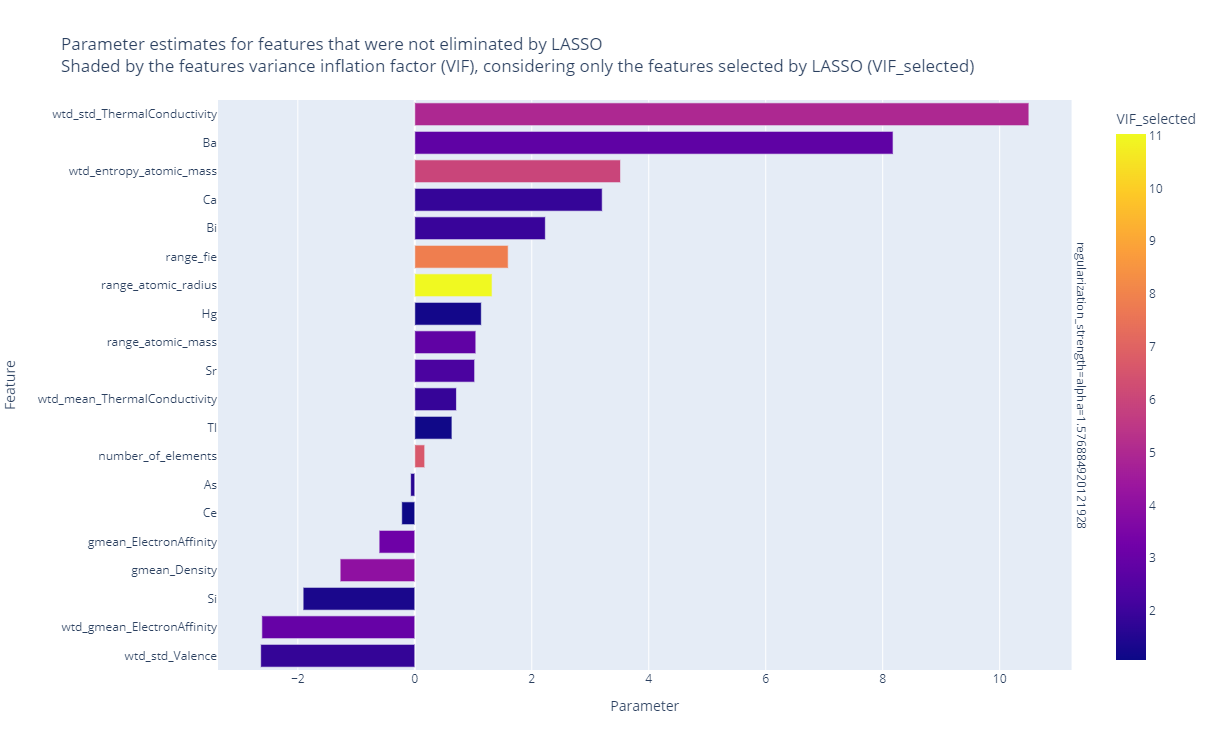

In [20]:
hover = {colname:(':.3f' if lasso_plot_dataframe.dtypes[colname] == float else True) for colname in lasso_plot_dataframe.columns}
hover["Parameter_abs"] = False

t = (f"Parameter estimates for features that were not eliminated by LASSO<br>"
     "Shaded by the features variance inflation factor (VIF), considering only the features selected by LASSO (VIF_selected)")

fig = px.bar(data_frame=lasso_plot_dataframe.sort_values(by=['regularization_strength', 'Parameter','Feature']), 
             y="Feature", 
             x="Parameter", 
             hover_data=hover, 
             color="VIF_selected",
             orientation="h",
             facet_row="regularization_strength",
             title=t, 
             height=750, 
             width=1000)
fig.update_yaxes(matches=None)
fig.show()

fig.write_image("./images/lasso_selected_coefs.jpeg")

#### 3.1.3 Lasso CV Metrics vs Regularization Strength

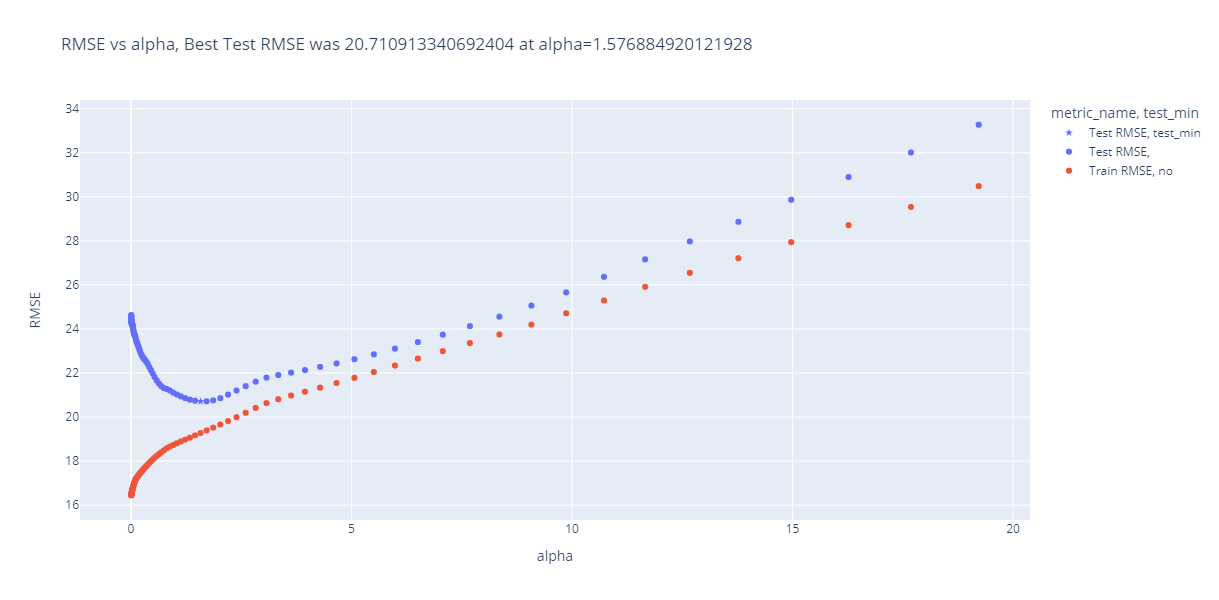

In [21]:
# Plot Lasso Cross-Validation Metrics vs Regularization Strength (Alpha)
f = plotly_train_test_compare(df=lc_gs_df.loc[lc_gs_df["fit_intercept"]==True,:], 
                              metric_y="RMSE", 
                              annotate_min=True, 
                              xmax=20)

f.show()
fig.write_image("./images/lasso_hyperparams.jpeg")

### 3.2 Ridge Models

$$
\begin{eqnarray}
Ridge \; Loss &=& SSE + L{2} \; Penalty &=& \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2 + \alpha\sum_{j=1}^p \beta_j^2
\end{eqnarray}
$$

#### 3.2.1 Ridge GridSearch

In [22]:
'''
a1 = np.logspace(start=-2.3, stop=0, num=50).tolist()
a2 = np.linspace(start=1.1, stop=2_000, num=150).tolist()
alphas = a1 + a2

model_pipe = Pipeline(steps=[("scaler", StandardScaler()), 
                             ("model", Ridge(max_iter=15_000, random_state=42))])

parameter_grid = {"model__alpha":alphas, 
                  "model__fit_intercept":[True, False]}

gs = run_gridsearch(X=X, 
                    y=y, 
                    estimator=model_pipe, 
                    param_grid=parameter_grid, 
                    save_name=get_gs_save_name(model_name="ridge"))''';

In [23]:
GS_FILENAME="ridge_20220904_1139_gs"
ridge_gs = load_gs_from_pickle(pickle_filepath=f"./models/{GS_FILENAME}.pkl")
ridge_best_params = ridge_gs.best_estimator_.named_steps["model"].get_params()
ridge_best_coefs = ridge_gs.best_estimator_.named_steps["model"].coef_
ridge_gs_df = pd.DataFrame(ridge_gs.cv_results_)
rc_gs_df = gs_to_clean_df(search_results=ridge_gs.cv_results_, task="regression")

#### 3.2.2 Best Ridge Model Coefficients

In [24]:
features = ridge_gs.best_estimator_[:-1].get_feature_names_out()

ridge_coef_df = pd.DataFrame({"Feature":features,
                              "Parameter":ridge_best_coefs})

ridge_coef_df = create_ridge_coef_plot_df(X=X_sc, 
                                          ridge_coef_df=ridge_coef_df, 
                                          lasso_coef_df=lasso_coef_df)

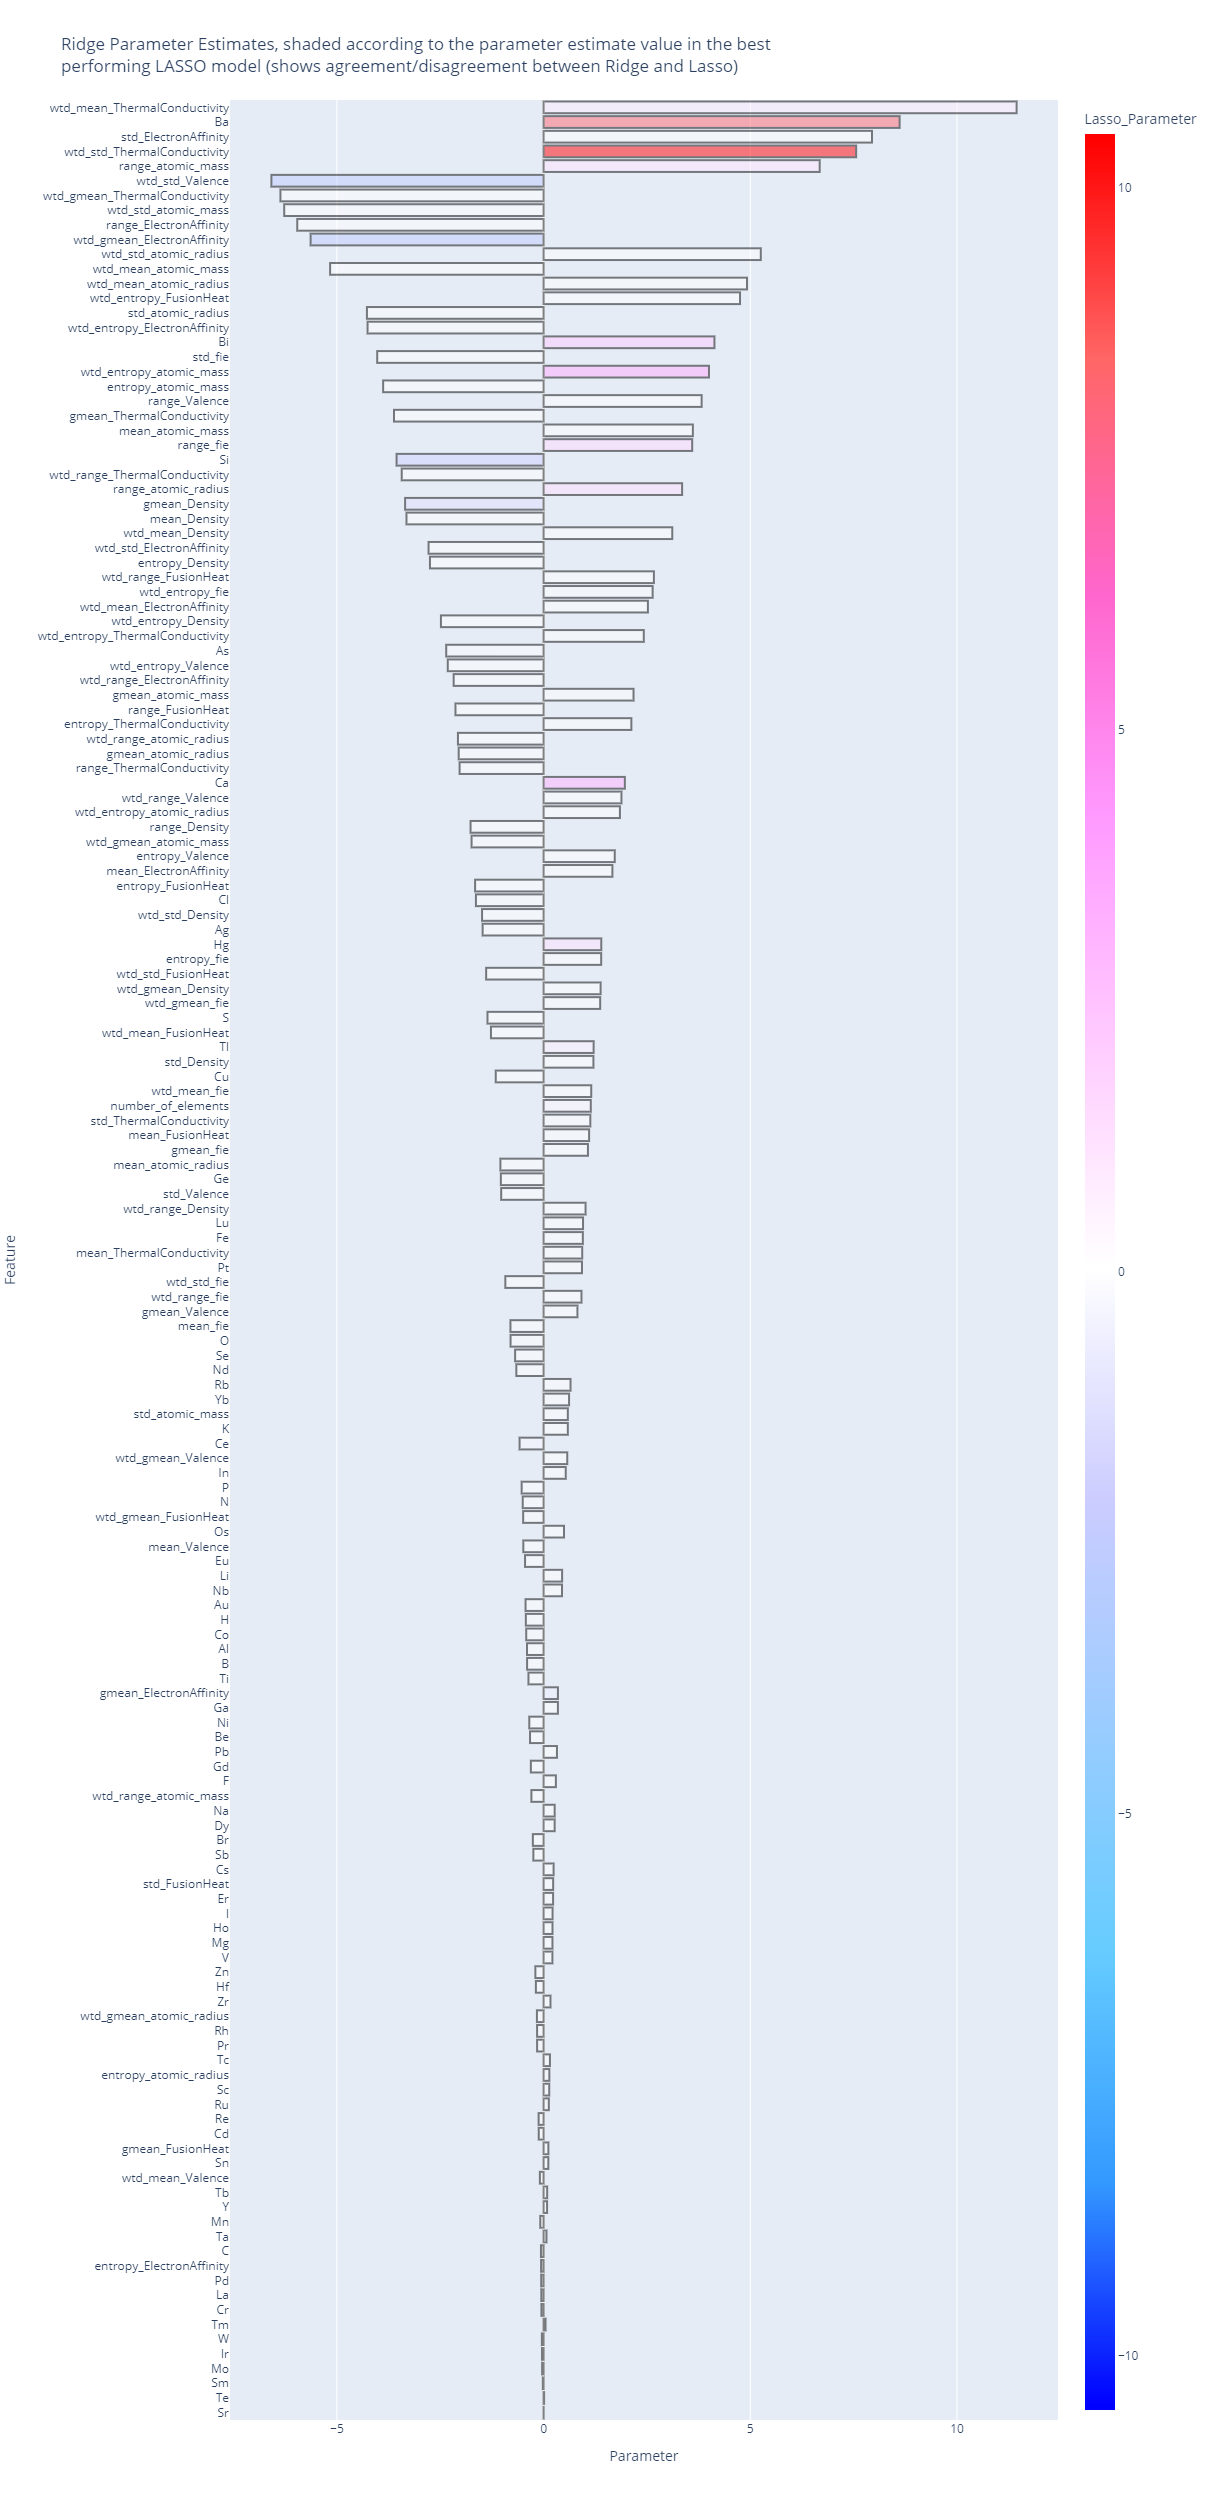

In [25]:
t = (f"Ridge Parameter Estimates, shaded according to the parameter estimate value in the best<br>"
     "performing LASSO model (shows agreement/disagreement between Ridge and Lasso)")

fig = px.bar(data_frame=ridge_coef_df, 
             y="Feature", 
             x="Parameter", 
             color="Lasso_Parameter", 
             hover_data={"VIF":True},
             orientation="h",
             barmode="overlay", 
             color_continuous_scale=px.colors.diverging.Picnic,
             color_continuous_midpoint =0,
             title=t, 
             height=2500, 
             width=1300)

fig.update_traces(marker=dict(line=dict(width=2,
                                        color='black')))

fig.show()
fig.write_image("./images/ridge_selected_coefs.jpeg")

#### 3.2.3 Ridge CV Metrics vs Regularization Strength

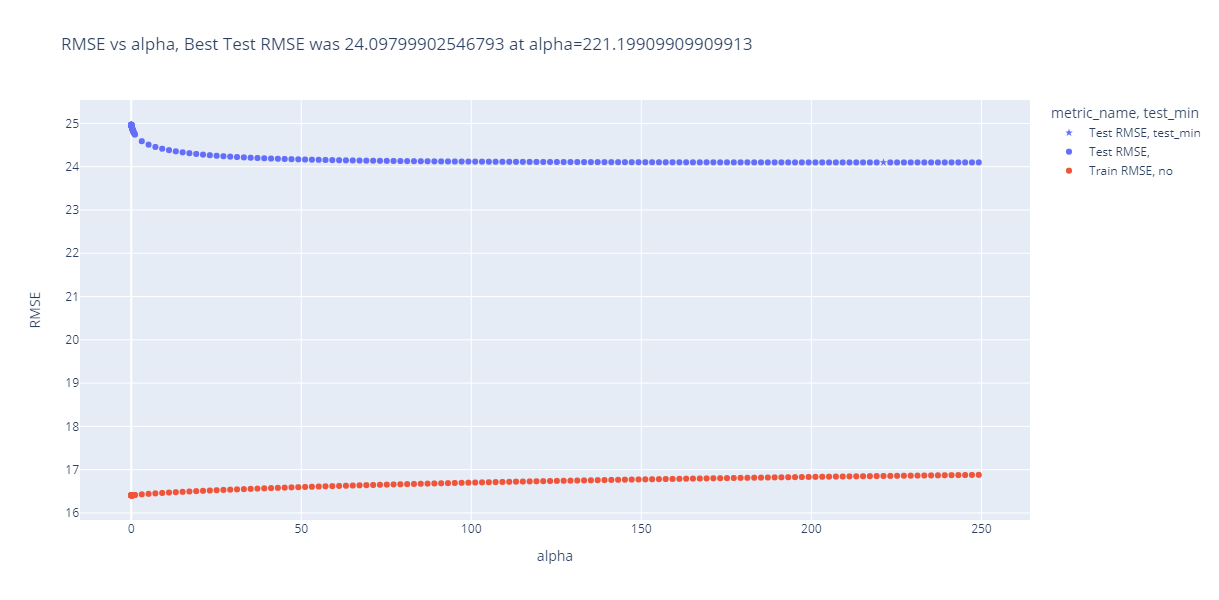

In [26]:
f = plotly_train_test_compare(df=rc_gs_df.loc[rc_gs_df["fit_intercept"]==True,:], 
                              metric_y="RMSE", 
                              annotate_min=True, 
                              xmax=250)

f.show()
fig.write_image("./images/ridge_hyperparams.jpeg")

### 3.3 ElasticNet Models

$$
\begin{eqnarray}
ElasticNet \: Loss = SSE + Ridge \: (L{2} \: Penalty) + Lasso \: (L{1} \: Penalty) &=& \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2 + \alpha\left[\rho\sum_{j=1}^p |\beta_j| + (1-\rho)\sum_{j=1}^p \beta_j^2\right] \\
&=& \|\mathbf{y} - \mathbf{X}\beta\|^2 + \alpha\left(\rho\|\beta\|_1 + (1 - \rho)\|\beta\|^2\right)
\end{eqnarray}
$$

#### 3.3.1 ElasticNet GridSearch

In [27]:
a1 = np.logspace(start=-2, stop=0, num=25).tolist()
a2 = np.linspace(start=1.1, stop=50, num=250).tolist()
alphas = a1 + a2

model_pipe = Pipeline(steps=[("scaler", StandardScaler()), 
                             ("model", ElasticNet(max_iter=15_000, random_state=42))])

parameter_grid = {"model__alpha":alphas, 
                  "model__l1_ratio":[0.01, 0.1, 0.2, 0.3, 0.4,
                                     0.5, 0.6, 0.7, 0.8, 0.9, 0.99]}

#gs = run_gridsearch(X=X, 
#                    y=y, 
#                    estimator=model_pipe, 
#                    param_grid=parameter_grid, 
#                    save_name=get_gs_save_name(model_name="elasticnet"))

In [28]:
GS_FILENAME="elasticnet_20220904_1728_gs"
enet_gs = load_gs_from_pickle(pickle_filepath=f"./models/{GS_FILENAME}.pkl")
enet_best_params = enet_gs.best_estimator_.named_steps["model"].get_params()
enet_best_coefs = enet_gs.best_estimator_.named_steps["model"].coef_
enet_gs_df = pd.DataFrame(enet_gs.cv_results_)

enetc_gs_df = gs_to_clean_df(search_results=enet_gs.cv_results_, task="regression")

#### 3.3.2 Best ElasticNet Model Coefficients

In [29]:
enet_plot_df = get_lasso_plot_df(X=X_sc, 
                                 y=y, 
                                 X_unscaled=X, 
                                 alpha=enet_best_params['alpha'], 
                                 l1_ratio=enet_best_params['l1_ratio'],
                                 run_rfecv=True, 
                                 model_type="elasticnet", 
                                 return_selected_only=True)

============================== Elasticnet Parameter Estimate Summary (Alpha=1.689156626506024) (l1_ratio = 0.99) =======================================
Number of Parameters Estimated: 158.0
Max Parameter Value: 10.120305866278
75th Percentile Parameter Value: -0.0
Mean Parameter Value: 0.16284444340782117
Median Parameter Value: -0.0
Min Parameter Value: -2.6223652838740374

Number of non-zero parameter estimates: 19
Number of Parameters Eliminated by Elasticnet (coef shrank to zero): 139

Features Eliminated By Lasso:
wtd_range_fie, Rb, Ga, Ge, As, Se, Br, entropy_atomic_mass, Cu, Y, Zr, Nb, Mo, Tc, Ru, Zn, Ni, Pd, K, Mg, Al, std_atomic_mass, P, S, Cl, wtd_range_atomic_mass, Co, Sc, Ti, V, Cr, Mn, Fe, Rh, Ag, std_fie, Re, Tm, Yb, Lu, Hf, Ta, W, Os, Cd, Ir, Pt, Au, gmean_atomic_mass, wtd_mean_atomic_mass, Pb, Er, Ho, Dy, Tb, Gd, Eu, Sm, Nd, Pr, La, wtd_gmean_atomic_mass, Cs, I, Te, Sb, Sn, In, Na, F, O, wtd_gmean_fie, range_Density, wtd_range_Density, std_Density, wtd_std_Density, mea

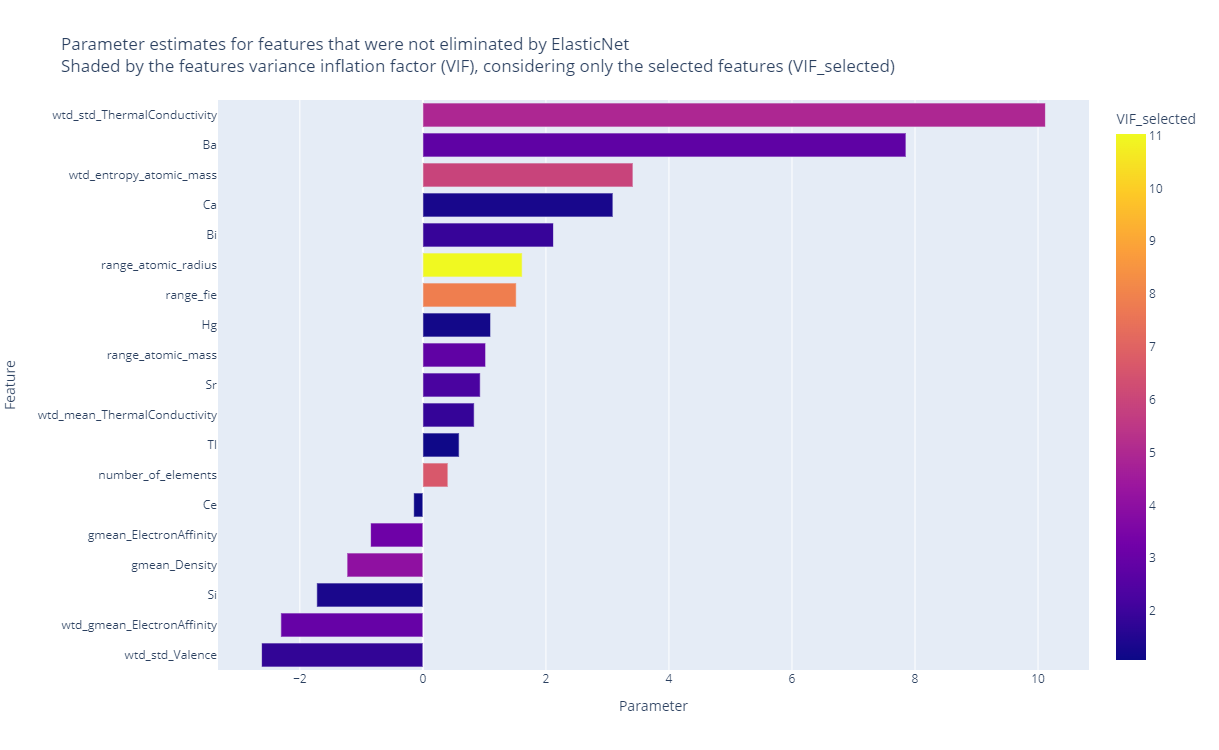

In [30]:
hover = {colname:(':.3f' if enet_plot_df.dtypes[colname] == float else True) for colname in enet_plot_df.columns}

t = (f"Parameter estimates for features that were not eliminated by ElasticNet<br>"
     "Shaded by the features variance inflation factor (VIF), considering only the selected features (VIF_selected)")

fig = px.bar(data_frame=enet_plot_df.sort_values(by=['Parameter','Feature']), 
             y="Feature", 
             x="Parameter", 
             hover_data=hover, 
             color="VIF_selected",
             orientation="h",
             title=t, 
             height=750, 
             width=1000)
fig.update_yaxes(matches=None)
fig.show()
#fig.write_image("./images/enet_selected_coefs.jpeg")

#### 3.3.3 Best ElasticNet Train vs Validation Metrics

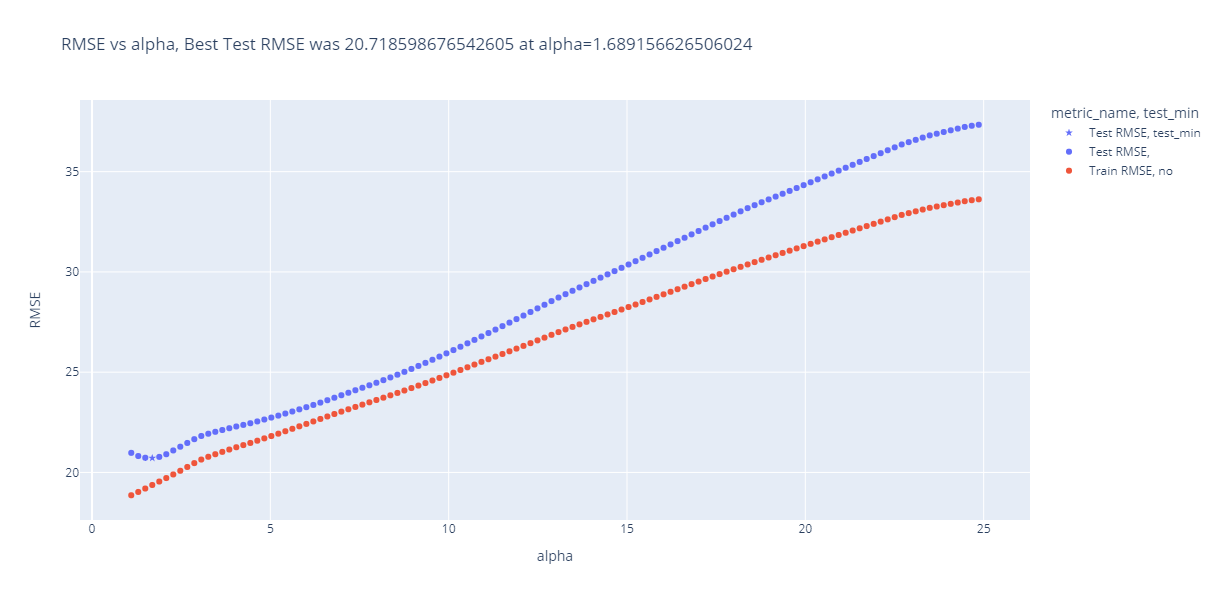

In [31]:
l1_ratio = 0.99

f = plotly_train_test_compare(df=enetc_gs_df.loc[enetc_gs_df["l1_ratio"]==l1_ratio,:], 
                              metric_y="RMSE", 
                              annotate_min=True, 
                              xmax=25, 
                              xmin=1.1)

f.show()
#fig.write_image("./images/enet_train_val_rmse.jpeg")

#### 3.3.4 ElasticNet CV Metrics vs Hyperparameters

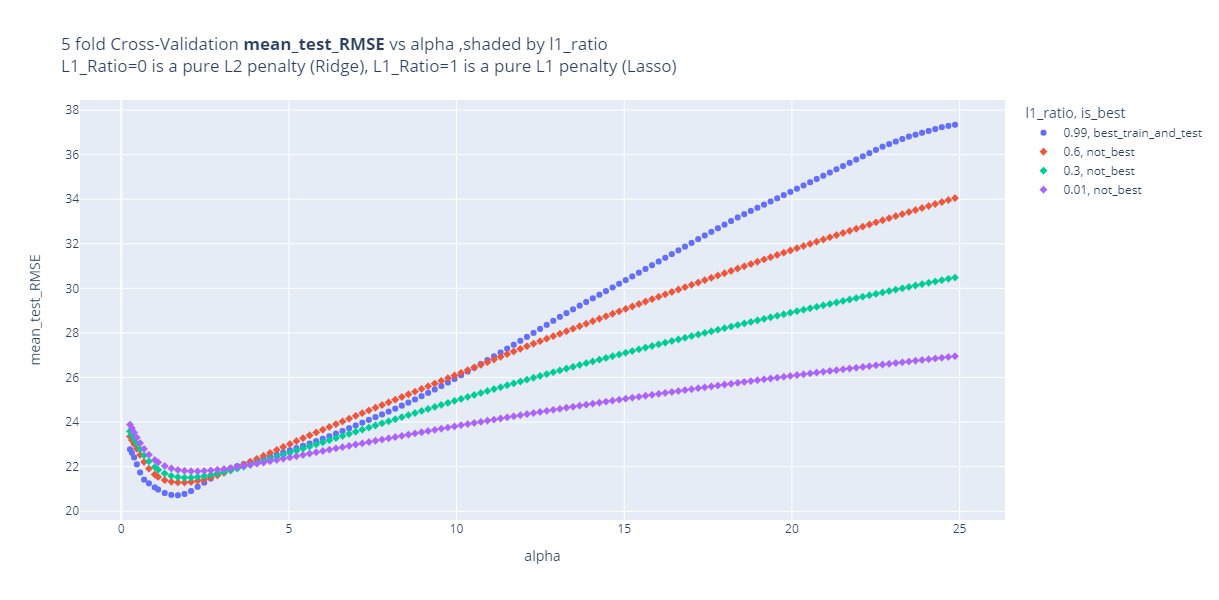

In [32]:
p_df = create_elastic_net_plot_df(gs_dataframe=enetc_gs_df, 
                                  shade_column_values=[0.01, 0.3, 0.6, 0.99], 
                                  metric_column_y="mean_test_RMSE", 
                                  shade_column="l1_ratio")



fig = create_metrics_scatter_plotly(plot_df=p_df, 
                                    hyperparam_column_x="alpha", 
                                    metric_column_y="mean_test_RMSE", 
                                    shade_column="l1_ratio", 
                                    symbol="is_best",
                                    xmin=0.25, 
                                    xmax=25)
fig.show()
#fig.write_image("./images/enet_hyperparams.jpeg")

## Section 4: Final Model Selection and Predictions


### 4.1.1 Best Lasso

In [33]:
model = Pipeline(steps=[("scaler", StandardScaler()), 
                        ("model", lasso_gs.best_estimator_)])


lasso_cv_t = cross_validate(estimator=model, 
                              X=X, 
                              y=y, 
                                 return_train_score=True, n_jobs=-1,
                              scoring=["neg_root_mean_squared_error", "r2"],
                              cv=KFold(n_splits=10, 
                                       shuffle=True, 
                                       random_state=42))

test_error = lasso_cv_t["test_neg_root_mean_squared_error"].mean()
train_error = lasso_cv_t["train_neg_root_mean_squared_error"].mean()
print(f"Train: {train_error}, Test:{test_error}")

Train: -19.410708114512047, Test:-20.447729705035197


### 4.1.2 Best Ridge

In [34]:
model = Pipeline(steps=[("scaler", StandardScaler()), 
                        ("model", ridge_gs.best_estimator_)])


ridge_cv_t = cross_validate(estimator=model, 
                              X=X, 
                              y=y, 
                                 return_train_score=True, n_jobs=-1,
                              scoring=["neg_root_mean_squared_error", "r2"],
                              cv=KFold(n_splits=10, 
                                       shuffle=True, 
                                       random_state=42))

test_error = ridge_cv_t["test_neg_root_mean_squared_error"].mean()
train_error = ridge_cv_t["train_neg_root_mean_squared_error"].mean()
print(f"Train: {train_error}, Test:{test_error}")

Train: -17.015780717787358, Test:-21.820435731907075


### 4.1.3 Best ElasticNet

In [35]:
model = Pipeline(steps=[("scaler", StandardScaler()), 
                        ("model", enet_gs.best_estimator_)])


enet_cv_t = cross_validate(estimator=model, 
                              X=X, 
                              y=y, 
                                 return_train_score=True, n_jobs=-1,
                              scoring=["neg_root_mean_squared_error", "r2"],
                              cv=KFold(n_splits=10, 
                                       shuffle=True, 
                                       random_state=42))

test_error = enet_cv_t["test_neg_root_mean_squared_error"].mean()
train_error = enet_cv_t["train_neg_root_mean_squared_error"].mean()
print(f"Train: {train_error}, Test:{test_error}")

Train: -19.505079435527175, Test:-20.392850460648006


### 4.1.4 Ensemble of best Lasso and Ridge Model

In [36]:
ensemble = VotingRegressor(estimators=[("ridge", ridge_gs.best_estimator_), 
                                       ("lasso", lasso_gs.best_estimator_)])

enet_ensemble_cv_t = cross_validate(estimator=ensemble, 
                              X=X, 
                              y=y, 
                                 return_train_score=True, n_jobs=-1,
                              scoring=["neg_root_mean_squared_error", "r2"],
                              cv=KFold(n_splits=10, 
                                       shuffle=True, 
                                       random_state=42))

test_error = enet_ensemble_cv_t["test_neg_root_mean_squared_error"].mean()
train_error = enet_ensemble_cv_t["train_neg_root_mean_squared_error"].mean()
print(f"Train: {train_error}, Test:{test_error}")

Train: -17.7647872696801, Test:-20.290085791156205


### 4.1.5 Ensemble of best Lasso and Ridge Model with yeo-johnson

In [37]:
best_ridge = Ridge(random_state=42, 
                   alpha=ridge_best_params['alpha'],
                   max_iter=15_000)

best_lasso = Lasso(random_state=42, 
                   alpha=lasso_best_params['alpha'],
                   max_iter=15_000)

ensemble = VotingRegressor(estimators=[("ridge", best_ridge), 
                                            ("lasso", best_lasso)])

yeo_ensemble = Pipeline(steps=[("yeo", PowerTransformer()), 
                                ("ensemble", ensemble)])

yeo_ensemble_cv = cross_validate(estimator=yeo_ensemble, 
                              X=X, 
                              y=y, 
                                 return_train_score=True, n_jobs=-1,
                              scoring=["neg_root_mean_squared_error", "r2"],
                              cv=KFold(n_splits=10, 
                                       shuffle=True, 
                                       random_state=42))

test_error = yeo_ensemble_cv["test_neg_root_mean_squared_error"].mean()
train_error = yeo_ensemble_cv["train_neg_root_mean_squared_error"].mean()
print(f"Train: {train_error}, Test:{test_error}")

Train: -16.40422477268822, Test:-16.449887827174734


### 4.1.5 Ensemble of best Lasso and Ridge Model with yeo-johnson and Polynomial Features

In [38]:
all_data = get_lasso_plot_df(X=X_sc, 
                            y=y, 
                            X_unscaled=X, 
                            alpha=lasso_best_params['alpha'], 
                            run_rfecv=False, 
                            print_summary=False)

rank_df = all_data[0]

In [39]:
lgbm_features = get_important_features(df=rank_df, metrics=["lgbm_gain_rank", "lgbm_split_rank"])
poly_feats = get_lasso_selected_from_gs(lasso_gs=lasso_gs) + lgbm_features
poly_df = get_polynomial_features_df(df=model_df.loc[:,poly_feats])
ensemble_lasso_poly_df = pd.concat(objs=[model_df, poly_df], axis="columns")

target_column = "critical_temp"
X_model_poly = ensemble_lasso_poly_df.drop(columns=target_column)
X_model_poly=X_model_poly.loc[:,~X_model_poly.columns.duplicated()]
y_model_poly = ensemble_lasso_poly_df[target_column].to_numpy()

best_ridge = Ridge(random_state=42, 
                   alpha=ridge_best_params['alpha'],
                   max_iter=15_000)

best_lasso = Lasso(random_state=42, 
                   alpha=lasso_best_params['alpha'],
                   max_iter=15_000)

ensemble = VotingRegressor(estimators=[("ridge", best_ridge), 
                                            ("lasso", best_lasso)])

ensemble_yeo_poly_pipe = Pipeline(steps=[("yeo", PowerTransformer()), 
                                ("ensemble", ensemble)])

ensemble_yeo_poly_pipe_cv = cross_validate(estimator=ensemble_yeo_poly_pipe, 
                                           X=X_model_poly, 
                                           y=y_model_poly, 
                                           return_train_score=True, 
                                           n_jobs=-1,
                                           scoring=["neg_root_mean_squared_error", 
                                                    "r2"],
                                           cv=KFold(n_splits=10, 
                                                    shuffle=True, 
                                                    random_state=42))

test_error = ensemble_yeo_poly_pipe_cv["test_neg_root_mean_squared_error"].mean()
train_error = ensemble_yeo_poly_pipe_cv["train_neg_root_mean_squared_error"].mean()
print(f"Lasso with alpha={lasso_best_params['alpha']}, ")
print(f"Ridge with alpha={ridge_best_params['alpha']},\n")
print(f"Polynomial features were used for: {poly_feats}\n")
print(f"Train: {train_error}, Test:{test_error}")

Lasso with alpha=1.576884920121928, 
Ridge with alpha=221.19909909909913,

Polynomial features were used for: ['number_of_elements', 'wtd_entropy_atomic_mass', 'range_atomic_mass', 'range_fie', 'range_atomic_radius', 'gmean_Density', 'gmean_ElectronAffinity', 'wtd_gmean_ElectronAffinity', 'wtd_mean_ThermalConductivity', 'wtd_std_ThermalConductivity', 'wtd_std_Valence', 'Si', 'Ca', 'As', 'Sr', 'Ba', 'Ce', 'Hg', 'Tl', 'Bi', 'Ba', 'Ca', 'Cu', 'wtd_gmean_Density', 'gmean_Valence', 'Ca', 'wtd_mean_ThermalConductivity', 'Cu', 'wtd_entropy_Density', 'wtd_mean_Valence']

Train: -14.47858425864528, Test:-14.59524921339062


In [40]:
lgbm_features = get_important_features(df=rank_df, metrics=["lgbm_gain_rank", "lgbm_split_rank"])
poly_feats = get_lasso_selected_from_gs(lasso_gs=lasso_gs) + lgbm_features
poly_df = get_polynomial_features_df(df=model_df.loc[:,poly_feats])
ensemble_lasso_poly_df = pd.concat(objs=[model_df, poly_df], axis="columns")

target_column = "critical_temp"
X_model_poly = ensemble_lasso_poly_df.drop(columns=target_column)
X_model_poly=X_model_poly.loc[:,~X_model_poly.columns.duplicated()]
y_model_poly = ensemble_lasso_poly_df[target_column].to_numpy()

best_ridge = Ridge(random_state=42, 
                   alpha=ridge_best_params['alpha'],
                   max_iter=15_000)

best_lasso = Lasso(random_state=42, 
                   alpha=lasso_best_params['alpha'],
                   max_iter=15_000)

ensemble = VotingRegressor(estimators=[("ridge", best_ridge), 
                                            ("lasso", best_lasso)])

ensemble_yeo_poly_pipe = Pipeline(steps=[("yeo", PowerTransformer()), 
                                ("ensemble", ensemble)])

ensemble_yeo_poly_pipe_cv = cross_validate(estimator=ensemble_yeo_poly_pipe, 
                                           X=X_model_poly, 
                                           y=y_model_poly, 
                                           return_train_score=True, 
                                           n_jobs=-1,
                                           scoring=["neg_root_mean_squared_error", 
                                                    "r2"],
                                           cv=KFold(n_splits=10, 
                                                    shuffle=True, 
                                                    random_state=42))

test_error = ensemble_yeo_poly_pipe_cv["test_neg_root_mean_squared_error"].mean()
train_error = ensemble_yeo_poly_pipe_cv["train_neg_root_mean_squared_error"].mean()
print(f"Lasso with alpha={lasso_best_params['alpha']}, ")
print(f"Ridge with alpha={ridge_best_params['alpha']},\n")
print(f"Polynomial features were used for: {poly_feats}\n")
print(f"Train: {train_error}, Test:{test_error}")

Lasso with alpha=1.576884920121928, 
Ridge with alpha=221.19909909909913,

Polynomial features were used for: ['number_of_elements', 'wtd_entropy_atomic_mass', 'range_atomic_mass', 'range_fie', 'range_atomic_radius', 'gmean_Density', 'gmean_ElectronAffinity', 'wtd_gmean_ElectronAffinity', 'wtd_mean_ThermalConductivity', 'wtd_std_ThermalConductivity', 'wtd_std_Valence', 'Si', 'Ca', 'As', 'Sr', 'Ba', 'Ce', 'Hg', 'Tl', 'Bi', 'Ba', 'Ca', 'Cu', 'wtd_gmean_Density', 'gmean_Valence', 'Ca', 'wtd_mean_ThermalConductivity', 'Cu', 'wtd_entropy_Density', 'wtd_mean_Valence']

Train: -14.47858425864528, Test:-14.59524921339062


In [41]:
lgbm_features = get_important_features(df=rank_df, metrics=["lgbm_gain_rank", "lgbm_split_rank"])
poly_feats = get_lasso_selected_from_gs(lasso_gs=lasso_gs) + lgbm_features
poly_df = get_polynomial_features_df(df=model_df.loc[:,poly_feats])
ensemble_lasso_poly_df = pd.concat(objs=[model_df, poly_df], axis="columns")

target_column = "critical_temp"
X_model_poly = ensemble_lasso_poly_df.drop(columns=target_column)
X_model_poly=X_model_poly.loc[:,~X_model_poly.columns.duplicated()]
y_model_poly = ensemble_lasso_poly_df[target_column].to_numpy()

best_ridge = Ridge(random_state=42, 
                   alpha=ridge_best_params['alpha'],
                   max_iter=15_000)

best_lasso = Lasso(random_state=42, 
                   alpha=lasso_best_params['alpha'],
                   max_iter=15_000)


ridge_yeo_poly_pipe = Pipeline(steps=[("yeo", PowerTransformer()), 
                                         ("ensemble", best_ridge)])

ridge_yeo_poly_pipe_cv = cross_validate(estimator=ridge_yeo_poly_pipe, 
                                           X=X_model_poly, 
                                           y=y_model_poly, 
                                           return_train_score=True, 
                                           n_jobs=-1,
                                           scoring=["neg_root_mean_squared_error", 
                                                    "r2"],
                                           cv=KFold(n_splits=10, 
                                                    shuffle=True, 
                                                    random_state=42))

test_error = ridge_yeo_poly_pipe_cv["test_neg_root_mean_squared_error"].mean()
train_error = ridge_yeo_poly_pipe_cv["train_neg_root_mean_squared_error"].mean()
print(f"Lasso with alpha={lasso_best_params['alpha']}, ")
print(f"Ridge with alpha={ridge_best_params['alpha']},\n")
print(f"Polynomial features were used for: {poly_feats}\n")
print(f"Train: {train_error}, Test:{test_error}")

Lasso with alpha=1.576884920121928, 
Ridge with alpha=221.19909909909913,

Polynomial features were used for: ['number_of_elements', 'wtd_entropy_atomic_mass', 'range_atomic_mass', 'range_fie', 'range_atomic_radius', 'gmean_Density', 'gmean_ElectronAffinity', 'wtd_gmean_ElectronAffinity', 'wtd_mean_ThermalConductivity', 'wtd_std_ThermalConductivity', 'wtd_std_Valence', 'Si', 'Ca', 'As', 'Sr', 'Ba', 'Ce', 'Hg', 'Tl', 'Bi', 'Ba', 'Ca', 'Cu', 'wtd_gmean_Density', 'gmean_Valence', 'Ca', 'wtd_mean_ThermalConductivity', 'Cu', 'wtd_entropy_Density', 'wtd_mean_Valence']

Train: -13.599284631206064, Test:-13.826184187665358


In [42]:
lgbm_features = get_important_features(df=rank_df, metrics=["lgbm_gain_rank", "lgbm_split_rank"])
poly_feats = get_lasso_selected_from_gs(lasso_gs=lasso_gs) + lgbm_features
poly_df = get_polynomial_features_df(df=model_df.loc[:,poly_feats])
ensemble_lasso_poly_df = pd.concat(objs=[model_df, poly_df], axis="columns")

target_column = "critical_temp"
X_model_poly = ensemble_lasso_poly_df.drop(columns=target_column)
X_model_poly=X_model_poly.loc[:,~X_model_poly.columns.duplicated()]
y_model_poly = ensemble_lasso_poly_df[target_column].to_numpy()


best_lasso = Lasso(random_state=42, 
                   alpha=lasso_best_params['alpha'],
                   max_iter=15_000)


lasso_yeo_poly_pipe = Pipeline(steps=[("yeo", PowerTransformer()), 
                                         ("ensemble", best_lasso)])

lasso_yeo_poly_pipe_cv = cross_validate(estimator=lasso_yeo_poly_pipe, 
                                           X=X_model_poly, 
                                           y=y_model_poly, 
                                           return_train_score=True, 
                                           n_jobs=-1,
                                           scoring=["neg_root_mean_squared_error", 
                                                    "r2"],
                                           cv=KFold(n_splits=10, 
                                                    shuffle=True, 
                                                    random_state=42))

test_error = lasso_yeo_poly_pipe_cv["test_neg_root_mean_squared_error"].mean()
train_error = lasso_yeo_poly_pipe_cv["train_neg_root_mean_squared_error"].mean()
print(f"Lasso with alpha={lasso_best_params['alpha']}, ")
print(f"Ridge with alpha={ridge_best_params['alpha']},\n")
print(f"Polynomial features were used for: {poly_feats}\n")
print(f"Train: {train_error}, Test:{test_error}")

Lasso with alpha=1.576884920121928, 
Ridge with alpha=221.19909909909913,

Polynomial features were used for: ['number_of_elements', 'wtd_entropy_atomic_mass', 'range_atomic_mass', 'range_fie', 'range_atomic_radius', 'gmean_Density', 'gmean_ElectronAffinity', 'wtd_gmean_ElectronAffinity', 'wtd_mean_ThermalConductivity', 'wtd_std_ThermalConductivity', 'wtd_std_Valence', 'Si', 'Ca', 'As', 'Sr', 'Ba', 'Ce', 'Hg', 'Tl', 'Bi', 'Ba', 'Ca', 'Cu', 'wtd_gmean_Density', 'gmean_Valence', 'Ca', 'wtd_mean_ThermalConductivity', 'Cu', 'wtd_entropy_Density', 'wtd_mean_Valence']

Train: -16.480478572057617, Test:-16.507799954434667


#### Top five features by lightgbm split and gain importance

In [43]:
rank_df.loc[rank_df.sort_values(by="lgbm_gain_rank").index[:5], 
            ["Feature", "lgbm_importance_gain", "lgbm_gain_rank"]].sort_values(by="lgbm_gain_rank")

Feature  lgbm_importance_gain  lgbm_gain_rank
36                  Cu          7.930764e+07               1
3                   Ca          6.034378e+06               2
1                   Ba          4.484756e+06               3
126      gmean_Valence          2.994664e+06               4
108  wtd_gmean_Density          2.499877e+06               5

In [44]:
rank_df.loc[rank_df.sort_values(by="lgbm_split_rank").index[:5], 
            ["Feature", "lgbm_importance_split", "lgbm_split_rank"]].sort_values(by="lgbm_split_rank")

Feature  lgbm_importance_split  lgbm_split_rank
36                             Cu                     80                1
14   wtd_mean_ThermalConductivity                     63                2
3                              Ca                     61                3
106           wtd_entropy_Density                     57                4
140              wtd_mean_Valence                     53                5

## Section 5: Best Model Feature Importances

Refitting the best ensemble model using all of the data

In [45]:
lgbm_features = get_important_features(df=rank_df, metrics=["lgbm_gain_rank", "lgbm_split_rank"])
poly_feats = get_lasso_selected_from_gs(lasso_gs=lasso_gs) + lgbm_features
poly_df = get_polynomial_features_df(df=model_df.loc[:,poly_feats])
ensemble_lasso_poly_df = pd.concat(objs=[model_df, poly_df], axis="columns")

target_column = "critical_temp"
X_model_poly = ensemble_lasso_poly_df.drop(columns=target_column)
X_model_poly=X_model_poly.loc[:,~X_model_poly.columns.duplicated()]
y_model_poly = ensemble_lasso_poly_df[target_column].to_numpy()


best_ridge = Ridge(random_state=42, 
                   alpha=ridge_best_params['alpha'],
                   max_iter=15_000)

best_lasso = Lasso(random_state=42, 
                   alpha=lasso_best_params['alpha'],
                   max_iter=15_000)


best_ensemble = VotingRegressor(estimators=[("ridge", best_ridge), 
                                            ("lasso", best_lasso)])


best_ensemble_pipe = Pipeline(steps=[("yeo", PowerTransformer()), 
                                ("ensemble", best_ensemble)])

best_ensemble_pipe.fit(X_model_poly, y_model_poly)

Pipeline(steps=[('yeo', PowerTransformer()),
                ('ensemble',
                 VotingRegressor(estimators=[('ridge',
                                              Ridge(alpha=221.19909909909913,
                                                    max_iter=15000,
                                                    random_state=42)),
                                             ('lasso',
                                              Lasso(alpha=1.576884920121928,
                                                    max_iter=15000,
                                                    random_state=42))]))])

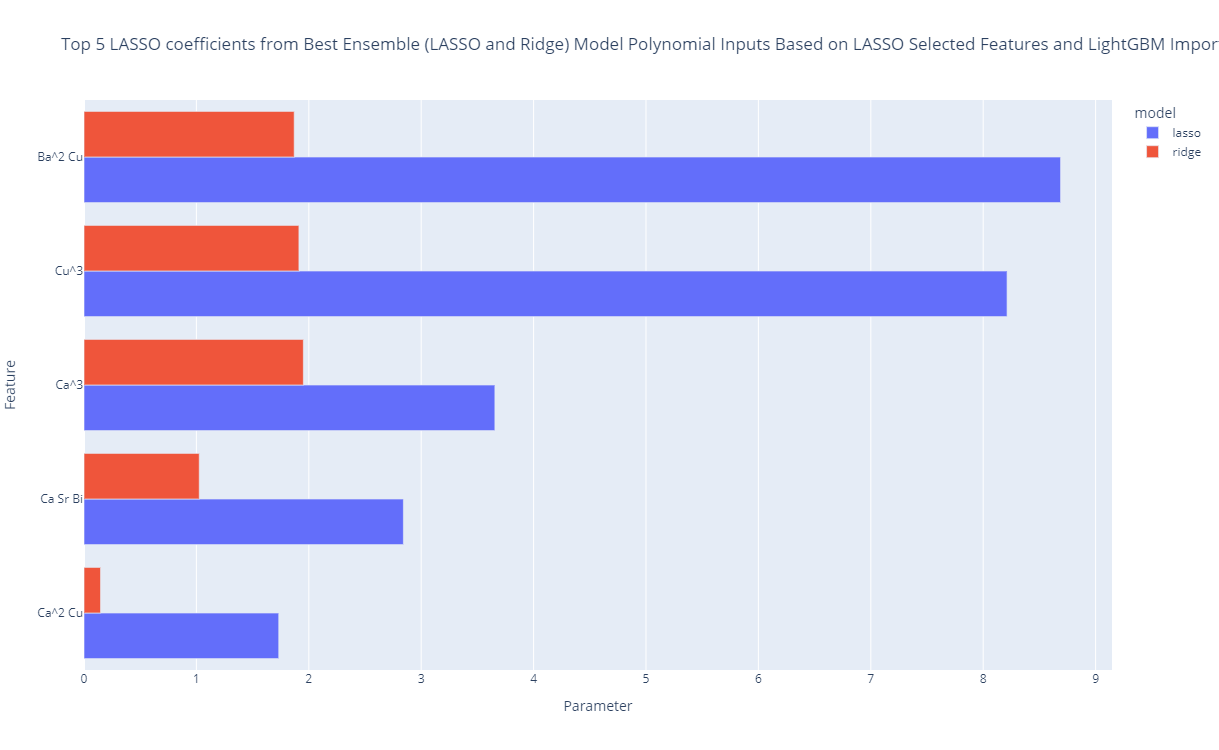

In [46]:
pinfo = get_ensemble_plot_info(ensemble_pipe=best_ensemble_pipe,  
                               num_top_features=5, 
                               ranking_model_name="lasso")

title = (f"Top 5 LASSO coefficients from Best Ensemble (LASSO and Ridge) Model\n" 
         "Polynomial Inputs Based on LASSO Selected Features and LightGBM Importance")

fig = px.bar(data_frame=pinfo['df'], 
             y="Feature", 
             x="Parameter", 
             color="model",
             orientation="h", 
             category_orders={"model":["lasso", "ridge"]},
             title=title, 
             barmode="group", 
             height=750, 
             width=1300)

fig.show()
fig.write_image("./images/BEST_ENSEMBLE_COEFS_LASSORANK.jpeg")

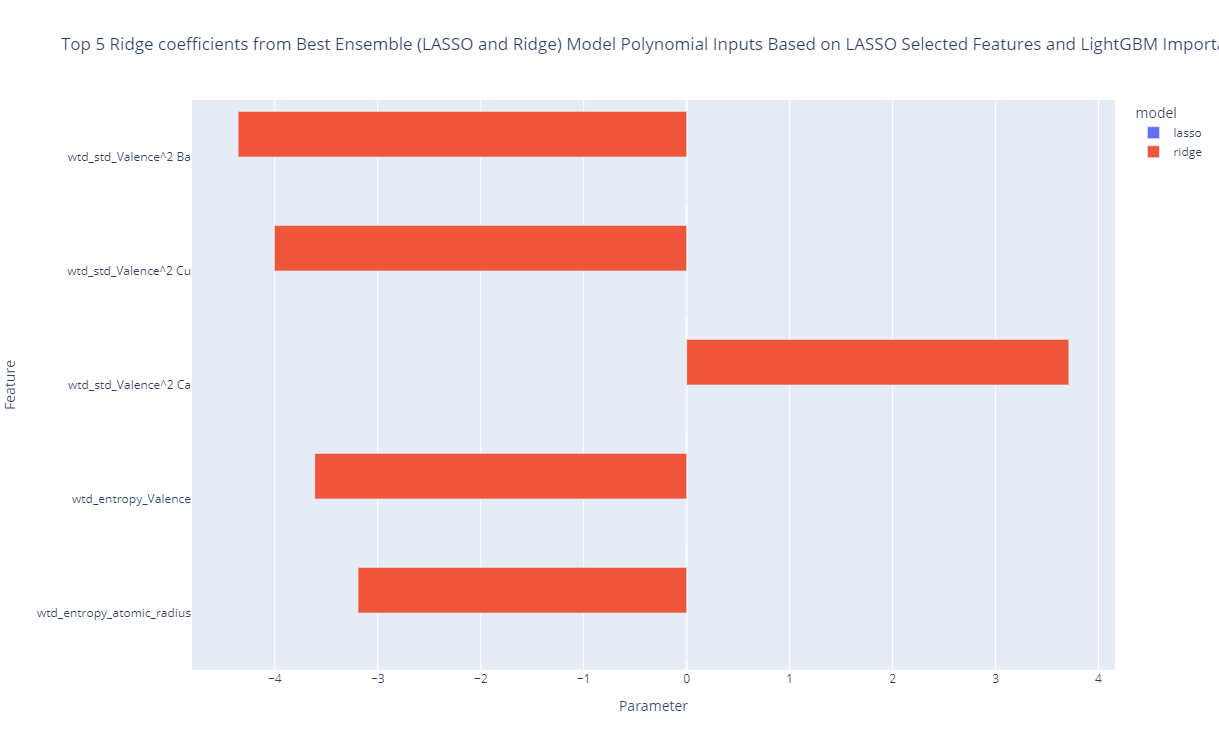

In [47]:
pinfo = get_ensemble_plot_info(ensemble_pipe=best_ensemble_pipe,  
                               num_top_features=5, 
                               ranking_model_name="ridge")


title = (f"Top 5 Ridge coefficients from Best Ensemble (LASSO and Ridge) Model\n" 
         "Polynomial Inputs Based on LASSO Selected Features and LightGBM Importance")

fig = px.bar(data_frame=pinfo['df'], 
             y="Feature", 
             x="Parameter", 
             color="model",
             orientation="h", 
             category_orders={"model":["lasso", "ridge"]},
             title=title, 
             barmode="group", 
             height=750, 
             width=1300)

fig.show()
fig.write_image("./images/BEST_RIDGERANK.jpeg")

In [48]:
lgbm_features = get_important_features(df=rank_df, metrics=["lgbm_gain_rank", "lgbm_split_rank"])
poly_feats = get_lasso_selected_from_gs(lasso_gs=lasso_gs) + lgbm_features
poly_df = get_polynomial_features_df(df=model_df.loc[:,poly_feats])
ensemble_lasso_poly_df = pd.concat(objs=[model_df, poly_df], axis="columns")

target_column = "critical_temp"
X_model_poly = ensemble_lasso_poly_df.drop(columns=target_column)
X_model_poly=X_model_poly.loc[:,~X_model_poly.columns.duplicated()]
y_model_poly = ensemble_lasso_poly_df[target_column].to_numpy()


best_lasso = Lasso(random_state=42, 
                   alpha=lasso_best_params['alpha'],
                   max_iter=15_000)

best_ridge = Ridge(random_state=42, 
                   alpha=ridge_best_params['alpha'],
                   max_iter=15_000)

best_ensemble_ridge = VotingRegressor(estimators=[("ridge", best_ridge)])


best_ensemble_pipe_ridge = Pipeline(steps=[("yeo", PowerTransformer()), 
                                           ("ensemble", best_ensemble_ridge)])

best_ensemble_pipe_ridge.fit(X_model_poly, y_model_poly)

Pipeline(steps=[('yeo', PowerTransformer()),
                ('ensemble',
                 VotingRegressor(estimators=[('ridge',
                                              Ridge(alpha=221.19909909909913,
                                                    max_iter=15000,
                                                    random_state=42))]))])

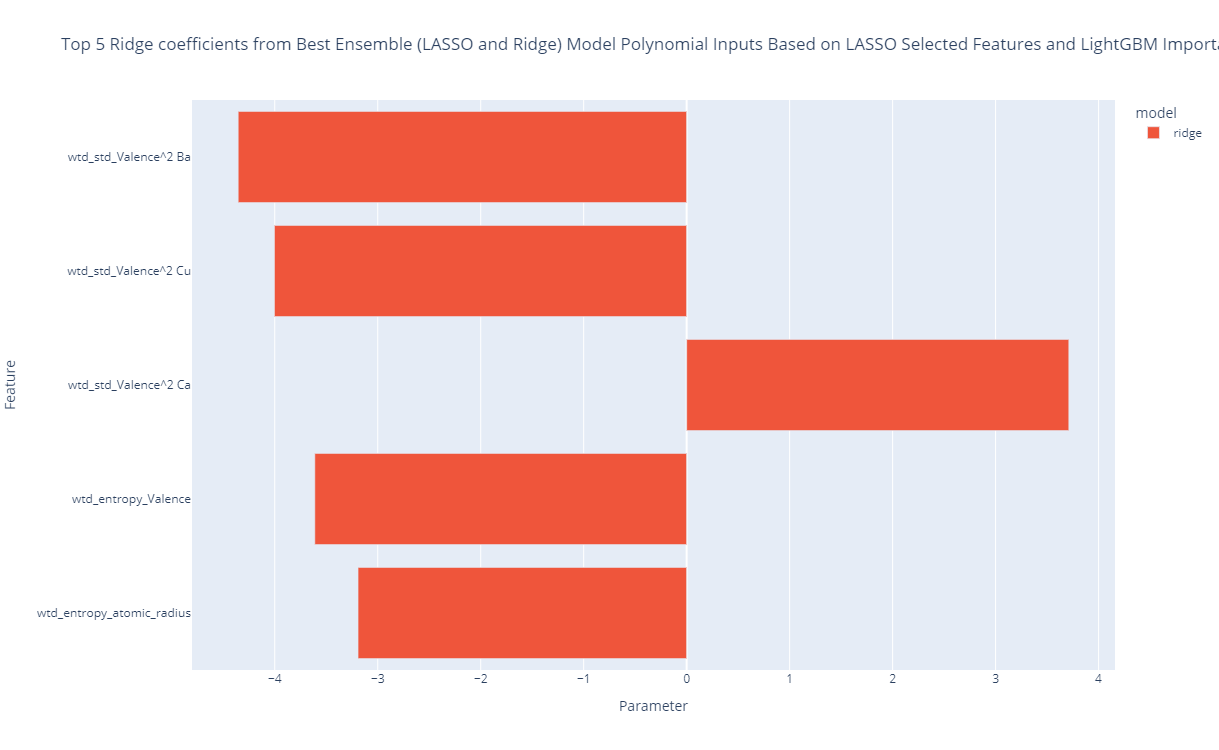

In [51]:
pinfo = get_ensemble_plot_info(ensemble_pipe=best_ensemble_pipe_ridge,  
                               num_top_features=5, 
                               ranking_model_name="ridge")


title = (f"Top 5 Ridge coefficients from Best Ensemble (LASSO and Ridge) Model\n" 
         "Polynomial Inputs Based on LASSO Selected Features and LightGBM Importance")

fig = px.bar(data_frame=pinfo['df'], 
             y="Feature", 
             x="Parameter", 
             color="model",
             orientation="h", 
             category_orders={"model":["lasso", "ridge"]},
             title=title, 
             barmode="group", 
             height=750, 
             width=1000)

fig.show()
fig.write_image("./images/BEST_RIDGE_ONLY.jpeg")